# Link Prediction in Ecological Networks using Latent Space Representation of Network Graphs - Main Document

This Jupyter Notebook is the main file used to train a link prediction model pipeline. Various food webs from the GATEWAy dataset are used as individual datasets. This process and its results are analysed in the following sections.


# Importing the necessarily libraries


In this section, the necessary libraries are imported or installed. Notably,  the following libraries and parts of their documentation were used for the making of this Jupyter Notebook: Pandas [1], Numpy [2], StellarGraph [3], DeepWalk (via KarateClub) [4], NetworkX [5], Matplotlib [6] and scikit-learn [7].

In [1]:
try:
  import stellargraph as sg
except:
  %pip install -q stellargraph[demos]==1.2.1

from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

In [2]:
try:
    import karateclub
except ModuleNotFoundError:
    ! pip install karateclub
from karateclub import DeepWalk

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests, zipfile, io
import os.path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

## Loading the data

The GATEWAy dataset [8] is automatically downloaded each time the notebook is run; there is no need to manually upload the dataset in Google Colab or similar platforms.

As a result, a .zip file is downloaded and then its contents are extracted. Afterwards, the relevant .csv file is loaded into a Pandas data frame.

In [4]:
file_name='283_2_FoodWebDataBase_2018_12_10.csv'

if not os.path.isfile(file_name):
  zip_file_url="https://idata.idiv.de/ddm/Data/DownloadZip/283?version=756"
  r = requests.get(zip_file_url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()

In [5]:
df = pd.read_csv('283_2_FoodWebDataBase_2018_12_10.csv', low_memory=False)
df.columns = df.columns.str.replace("[.]", "_")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


## Defining the used functions

In this section, we define the various functions used for the purpose of running the link prediction pipeline. The functions work as follows:

`deepwalk_representations`: this function uses the DeepWalk algorithm to generate latent space respresentations of the graph's nodes

`connect_samples_with_node_embeddings`: this function creates the feature representations of edges, by developing the learned feature representations of the individual nodes using binary operators.

`train_model`: this function is used to call the classifier and feed it the samples and their labels.

`get_classifier`: this function defines the classifier model, its hyperparameters before finally standardising the data.

`model_evaluation`: this is a general function for evaluating the model, with its purpose being to call to call the connect_samples_with_node_embeddings and the get_score functions.

`get_score`: this function returns the ROC AUC score of the examined food web for after the training and evaluation of the model is complete. During Validation Phase, it also draws the ROC curves for each web.

`find_best_operator`: this function is used for the Binary Operator Selector and Training Phase to search for the best binary operator. It first trains the model on the Training Set and then evaluates the trained model on the Binary Operator Selector Set, for all four binary operators. This produces four different ROC AUC scores, one for each operator, and the binary operator with the highest score is selected for evaluation of the model in the Validation phase.

`Average, Hadamard, Weighted_L1, Weighted_L2`: these functions return the binary product of the two pairs of vectors that are given as an input, each one using a different operation.


In [6]:
def deepwalk_representations(graph):
  modelDeep = DeepWalk(walk_length=number_of_walks, dimensions=number_of_dimensions, seed=0)
  modelDeep.fit(graph.to_networkx())

  def node_embeddings(vector):
    return modelDeep.get_embedding()[vector]
  return node_embeddings

  
def connect_samples_with_node_embeddings(link_samples, node_embeddings, binary_operator):
    _z=[]
    for source, destination in link_samples:
      _z.append(binary_operator(node_embeddings(source), node_embeddings(destination)))
    return _z


def train_model(link_samples, link_labels, node_embeddings, binary_operator):
    clf = get_classifier()
    link_features = connect_samples_with_node_embeddings(link_samples, node_embeddings, binary_operator)
    clf.fit(link_features, link_labels)
    return clf


def get_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=number_of_folds, scoring="roc_auc", max_iter=number_of_iterations)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])



def model_evaluation(clf, link_samples_test, link_labels_test, node_embeddings, binary_operator, validation_phase=False):
    link_features_test = connect_samples_with_node_embeddings(link_samples_test, node_embeddings, binary_operator)
    score = get_score(clf, link_features_test, link_labels_test, validation_phase)
    return score


def get_score(clf, link_features, link_labels, validation_phase=False):
    predicted = clf.predict_proba(link_features)
    positives = list(clf.classes_).index(1)
    
    if validation_phase==True:
      display = RocCurveDisplay.from_predictions(link_labels, predicted[:, positives], name='LogisticRegressionCV')
      _ = display.ax_.set_title(name)
      _ = display.ax_.set_xlabel('1 - Specificity')
      _ = display.ax_.set_ylabel('Sensitivity')
      
    return roc_auc_score(link_labels, predicted[:, positives])



def Average(a, b):
    return (a+b)/2.0

def Hadamard(a, b):
    return a*b

def Weighted_L1(a, b):
    return np.abs(a-b)

def Weighted_L2(a, b):
    return (a-b)**2

binary_operators = [Average, Hadamard, Weighted_L1, Weighted_L2]

def find_best_operator(binary_operator):
    clf = train_model(samples_train, labels_train, embedding_train, binary_operator)
    score = model_evaluation(clf, samples_model_selection, labels_model_selection, embedding_train, binary_operator)
    return {"classifier": clf,"binary_operator": binary_operator,"score": score}

## Model pipeline implementation

This part serves as the main part of the link prediction pipeline. First, the dataframe is sliced so that only one chosen food web is selected, forming a new, individual dataset. A total of seven food webs are chosen: Weddell Sea, Chesapeake Bay, Lough Hyne, Carpinteria, FloridaIslandE3, FloridaIslandE1 and Caribbean Reef.

Each individual dataset is then loaded into NetworkX as directed graph, with the columns `con_taxonomy` and `res_taxonomy` representing the pairs of nodes. The resulting NetworkX object then has its nodes converted to integers and is then loaded into the StellarGraph library as a directed multigraph.

The data is then separated into three different sets: the Training Set (used for training the model), the Binary Operator Test Set (used for selecting the optimal binary operator) and the Testing Set (used for evaluating the trained model). These sets are then employed to train and test the link prediction model. For more information on this procedure, refer to the Methodology section of the Dissertation-Research Paper.

In [7]:
list_of_webs=["Weddell Sea", "Chesapeake Bay", "Lough Hyne",
              "Carpinteria", "FloridaIslandE3", "FloridaIslandE1", "Caribbean Reef"]

#Uncomment the line below to only test one web
#list_of_webs=["Lough Hyne"]

number_of_folds=10
number_of_iterations=2000
number_of_walks=10
number_of_dimensions=16

** Sampled 3124 positive and 3124 negative edges. **
** Sampled 2811 positive and 2811 negative edges. **
** Sampled 2822 positive and 2822 negative edges. **
** Sampled 2540 positive and 2540 negative edges. **
** Sampled 1006 positive and 1006 negative edges. **
** Sampled 905 positive and 905 negative edges. **
** Sampled 589 positive and 589 negative edges. **
** Sampled 530 positive and 530 negative edges. **
** Sampled 721 positive and 721 negative edges. **
** Sampled 649 positive and 649 negative edges. **
** Sampled 701 positive and 701 negative edges. **
** Sampled 631 positive and 631 negative edges. **
** Sampled 659 positive and 659 negative edges. **
** Sampled 593 positive and 593 negative edges. **


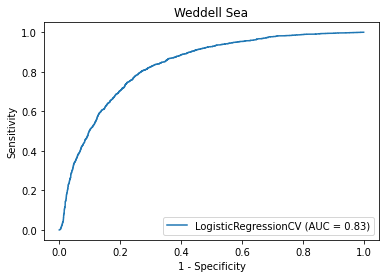

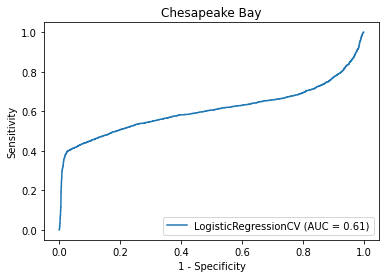

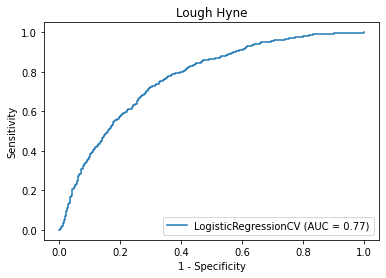

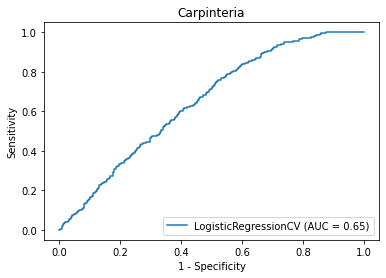

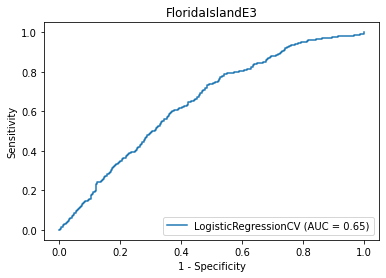

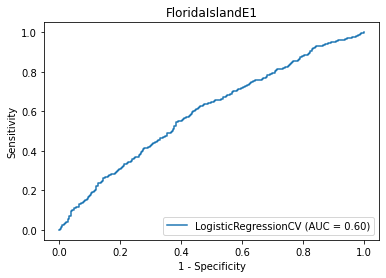

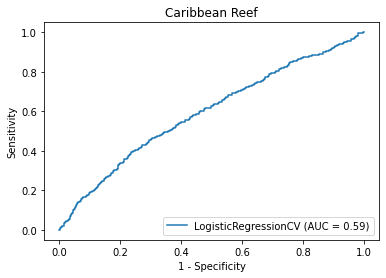

In [8]:
list_location=[]
list_score=[]
list_operator=[]


for name in list_of_webs:
  try:
    df_individual_web=df.loc[df.foodweb_name==name]

    G = nx.from_pandas_edgelist(df_individual_web, "con_taxonomy", "res_taxonomy")
    G = nx.DiGraph(G)
    G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default')
    G = StellarGraph.from_networkx(G)

    edge_splitter_test = EdgeSplitter(G)
    graph_test, samples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")



    edge_splitter_train = EdgeSplitter(graph_test, G)
    graph_train, samples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")
    (samples_train,samples_model_selection,labels_train,labels_model_selection) = train_test_split(samples, labels, train_size=0.75, test_size=0.25)


      
    embedding_train = deepwalk_representations(graph_train)



    operator_products=[]
    for binary_operator in binary_operators:
      operator_products.append(find_best_operator(binary_operator))

    optimal_operator = max(operator_products, key=lambda product: product["score"])

    embedding_test = deepwalk_representations(graph_test)
    test_score = model_evaluation(optimal_operator["classifier"],samples_test,labels_test,embedding_test,optimal_operator["binary_operator"], validation_phase=True)
    


  except:
    print(name, ' had an error')
    pass

  list_location.append(name)
  list_score.append(test_score)
  list_operator.append(str(optimal_operator["binary_operator"].__name__))


## Results reporting and recording

The results of the tests of the link prediction model are displayed here in the form of Pandas data frame. The results are also recorded in a .csv file.

In [9]:
df_results=pd.DataFrame(list(zip(list_location,list_score,list_operator)), columns=['Locale','ROC AUC score','Binary operator used'])
df_results

,Locale,ROC AUC score,Binary operator used
0,Weddell Sea,0.832760,Hadamard
1,Chesapeake Bay,0.607117,Hadamard
2,Lough Hyne,0.770068,Hadamard
3,Carpinteria,0.648395,Hadamard
4,FloridaIslandE3,0.647238,Hadamard
5,FloridaIslandE1,0.596118,Average
6,Caribbean Reef,0.593427,Average


In [10]:
df_results.to_csv('results.csv', index=False)

# References


[1] McKinney, W., 2022. Pandas documentation. pandas documentation - pandas 1.4.3 documentation. Available at: https://pandas.pydata.org/docs/ [Accessed August 12, 2022]. 

[2] Oliphant, T., 2022. NumPy documentation. NumPy documentation - NumPy v1.23 Manual. Available at: https://numpy.org/doc/stable/ [Accessed August 12, 2022]. 

[3] Data61, 2022. Stellargraph documentation. Welcome to StellarGraph's documentation! - StellarGraph 1.2.1 documentation. Available at: https://stellargraph.readthedocs.io/en/stable/ [Accessed August 12, 2022].

[4] Rozemberczki, B., 2022. Karate Club documentation. Karate Club Documentation - karateclub documentation. Available at: https://karateclub.readthedocs.io/en/latest/ [Accessed August 12, 2022]. 

[5] Hagberg, A., Swart, P. &amp; Schult, D., 2014. NetworkX documentation. NetworkX documentation - NetworkX 1.9 documentation. Available at: https://networkx.org/documentation/networkx-1.9/ [Accessed August 12, 2022]. 

[6] Hunter, J.D., 2022. Matplotlib 3.5.3 documentation. Matplotlib documentation - Matplotlib 3.5.3 documentation. Available at: https://matplotlib.org/stable/index.html [Accessed August 12, 2022]. 

[7] Cournapeau, D., 2022. scikit-learn Machine Learning in Python. scikit. Available at: https://scikit-learn.org/stable/ [Accessed August 12, 2022]. 

[8] Brose, U. et al., 2019. Predator traits determine food-web architecture across ecosystems. Nature Ecology &amp; Evolution, 3(6), pp.919–927. 